In [1]:
import itertools
from datetime import datetime

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# функция для обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [5]:
import os
os.chdir('/content/drive/MyDrive/YellowTaxi')

In [6]:
df = pd.read_csv('data/cleared_start_yellow_tripdata.csv')
df['date'] = pd.to_datetime(df['date'])
df.head()

,index,date,start_region,trips_count
0,1074,2015-01-15 19:00:00,1075,112
1,1075,2015-01-15 19:00:00,1076,170
2,1076,2015-01-15 19:00:00,1077,168
3,1124,2015-01-15 19:00:00,1125,194
4,1125,2015-01-15 19:00:00,1126,379


In [7]:
df_train = df[df['date']<datetime.strptime('2016-06-01',"%Y-%m-%d")]
print(df_train.shape)
df_test = df[df['date']>=datetime.strptime('2016-06-01',"%Y-%m-%d")]
print(df_test.shape)

(1227456, 4)
(70560, 4)


In [ ]:
# Задание 1.
#Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок.
#Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов

In [8]:
# выбранный для работы регион
REGION = 1282

def CurrentRegionTransformation(df, region):
    data = df[df.start_region == region].set_index(['date'])
    data.drop(['index', 'start_region'], axis=1, inplace= True)
    data.sort_index(inplace=True)
    return data

df_train = CurrentRegionTransformation(df_train, REGION)
print(df_train.shape)
df_test = CurrentRegionTransformation(df_test, REGION)
print(df_test.shape)

(12408, 1)
(720, 1)


In [9]:
cell_data = df_train.copy()

In [10]:
# Преобразование в среднее по суткам. Используем только для визуализации.
def mid_day(trips):
    mid_trips = []
    ids = list(range(0,len(trips)+1,24))
    ex_id = 0
    for i in ids:
        if i == 0:
            continue
        mid_trips.append(trips[ex_id:i].mean())
        ex_id = i
    return np.array(mid_trips)

In [11]:
#Создайте регрессионные признаки для учёта сезонностей и трендов
from sklearn import linear_model, model_selection, metrics

def add_features(cell_data, k):
    cell_data['const'] = 1
    cell_data['lin'] = np.arange(1, cell_data.shape[0]+1)
    real_columns = ['const', 'lin']
    for i in range(1, k+1):
        week_sin_col = 'week_sin_{}'.format(i)
        week_cos_col = 'week_cos_{}'.format(i)

        cell_data[week_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        cell_data[week_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 168))

        real_columns += [week_sin_col, week_cos_col]    
    
    return real_columns

In [ ]:
# Задание 2.
# Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака
#  — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. 
# Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность.
# Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего,
# увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [12]:
# Обучение модели, добаление предсказаний и остатков в датафрейм. Возвращает предсказанные значения.
def get_reg_pred(cell_data, features_columns):
    train_data = np.array(cell_data[features_columns])
    train_labels = np.array(cell_data['trips_count'])
    
    model = linear_model.LinearRegression()
    model.fit(train_data, train_labels)
    
    preds = model.predict(cell_data[features_columns])
    
    cell_data['reg_pred'] = preds
    cell_data['reg_resid'] = cell_data['trips_count'] - preds
    
    return preds

In [13]:
# Для вывода на печать
def simple_plot(labels, trips, min_lim=None, max_lim=None, title=''):
    """
    labels -список с datetime.datetime объектами
    min_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Минимальная дата отрисовки
    max_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Максимальная дата отрисовки
    title - заголовок
    """
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(labels, trips)
    ax.set_xlabel('Hours', fontsize=15)

    ax.set_ylabel('Trips', fontsize=15)
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    """
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('left')
    """
    ax.grid(True)
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title, fontsize=30, y=1.01)

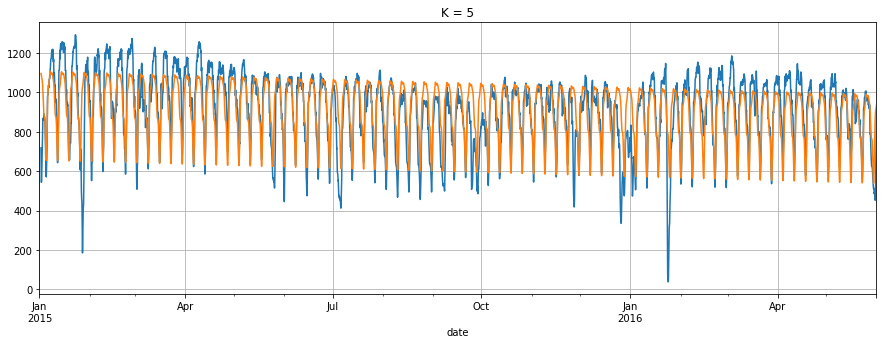

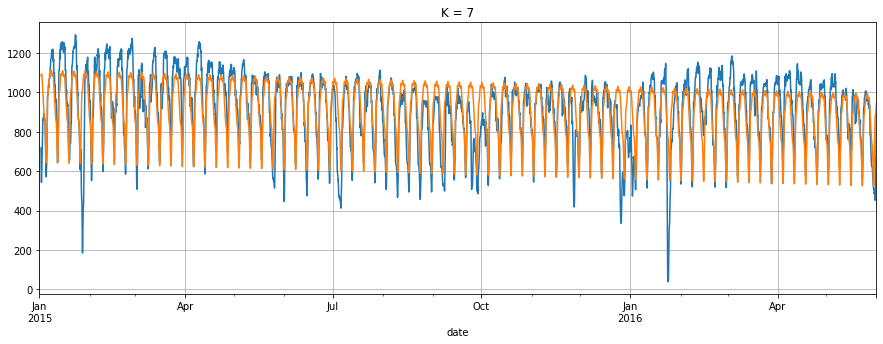

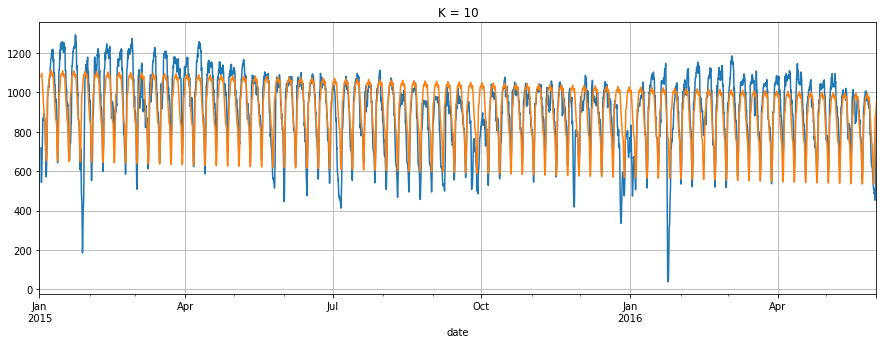

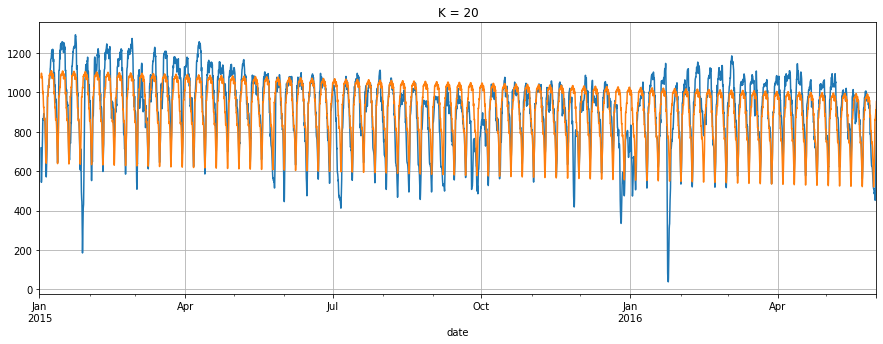

In [14]:
ks = [5, 7, 10, 20]
for k in ks:
    features_columns = add_features(cell_data, k)
    reg_pred = get_reg_pred(cell_data, features_columns)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    cell_data['trips_count'].rolling(24).mean().plot(ax=ax)
    cell_data['reg_pred'].rolling(24).mean().plot(ax=ax)
    ax.set_title('K = {}'.format(k))
    plt.grid(True)

    plt.show()
    
    cell_data.drop(columns=features_columns + ['reg_pred', 'reg_resid'], inplace=True)

In [15]:
# Примем K= 7
K = 7
features_columns = add_features(cell_data, K)
reg_pred = get_reg_pred(cell_data, features_columns)
cell_data['reg_resid'] = cell_data['trips_count'] - reg_pred
cell_data.head()

,trips_count,const,lin,week_sin_1,week_cos_1,week_sin_2,week_cos_2,week_sin_3,week_cos_3,week_sin_4,week_cos_4,week_sin_5,week_cos_5,week_sin_6,week_cos_6,week_sin_7,week_cos_7,reg_pred,reg_resid
date,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1340,1,1,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,0.974928,0.258819,0.965926,919.892971,420.107029
2015-01-01 01:00:00,1236,1,2,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,0.900969,0.500000,0.866025,749.157786,486.842214
2015-01-01 02:00:00,1147,1,3,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,0.781831,0.707107,0.707107,602.863619,544.136381
2015-01-01 03:00:00,744,1,4,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,0.623490,0.866025,0.500000,490.659124,253.340876
2015-01-01 04:00:00,374,1,5,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,0.433884,0.965926,0.258819,419.858576,-45.858576


In [16]:
cell_data['reg_resid']

date
2015-01-01 00:00:00    420.107029
2015-01-01 01:00:00    486.842214
2015-01-01 02:00:00    544.136381
2015-01-01 03:00:00    253.340876
2015-01-01 04:00:00    -45.858576
                          ...    
2016-05-31 19:00:00    322.661782
2016-05-31 20:00:00    236.053437
2016-05-31 21:00:00    194.673782
2016-05-31 22:00:00    -26.324337
2016-05-31 23:00:00   -268.189007
Name: reg_resid, Length: 12408, dtype: float64

In [17]:
# Печать декомпозиции.
def dec_plot(pd_series):
    dec_obj = sm.tsa.seasonal_decompose(pd_series)
    simple_plot(np.array(pd_series.index)[::24][:len(mid_day(dec_obj.observed))], 
                mid_day(dec_obj.observed), title='Obs')
    simple_plot(np.array(pd_series.index)[::24][:len(mid_day(dec_obj.trend))], 
                mid_day(dec_obj.trend), title='Trend')
    simple_plot(np.array(pd_series.index), np.array(dec_obj.seasonal), title='Seasonal')
    simple_plot(np.array(pd_series.index)[::24][:len(mid_day(dec_obj.observed))], 
                mid_day(dec_obj.resid), title='Resid')
    return dec_obj

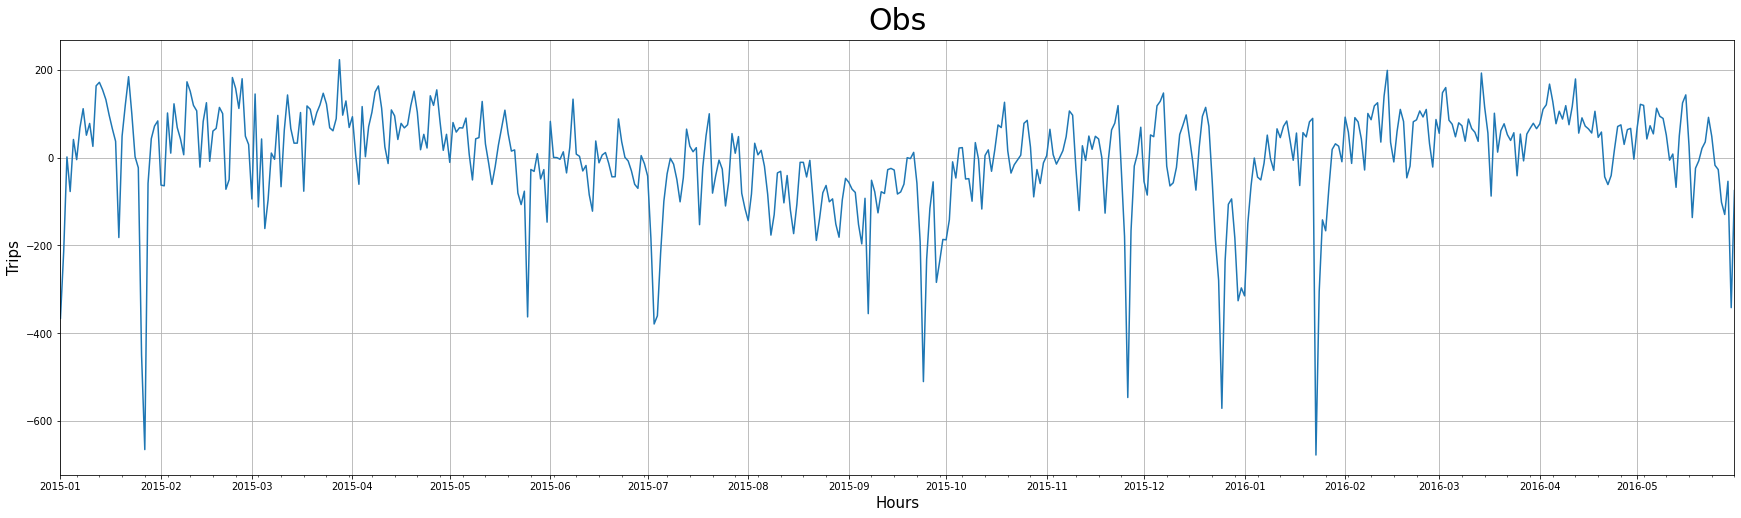

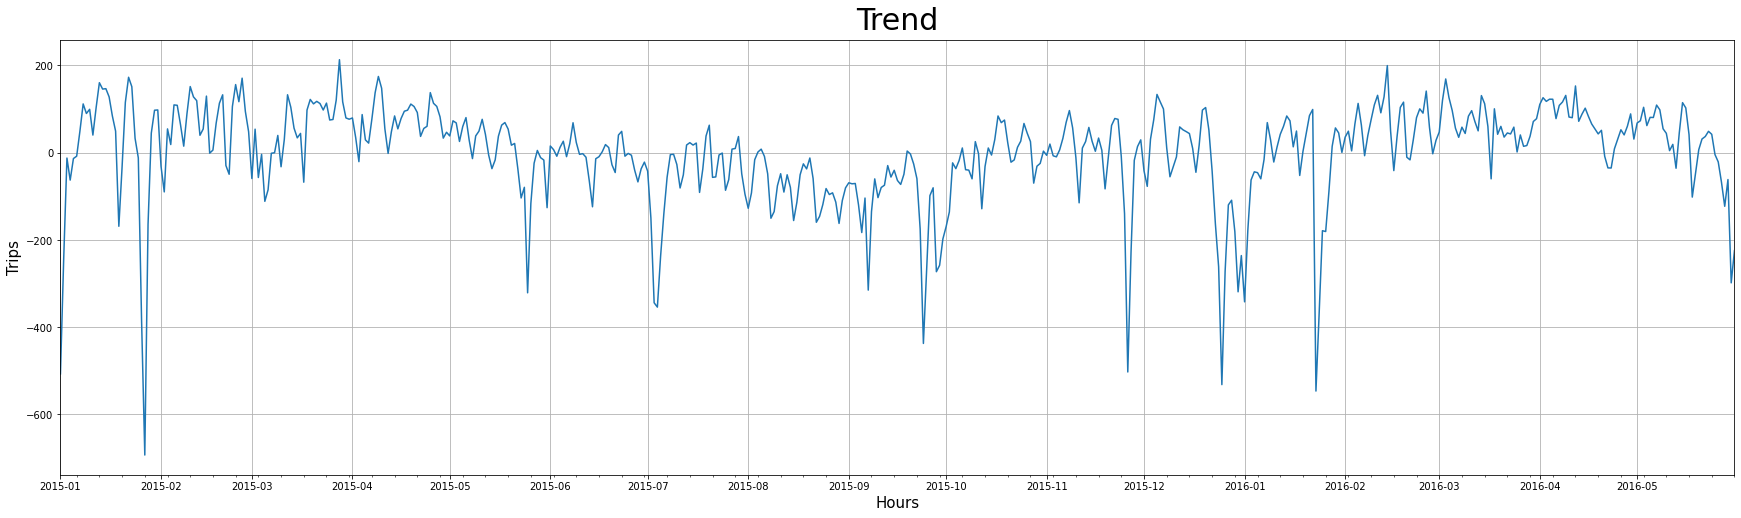

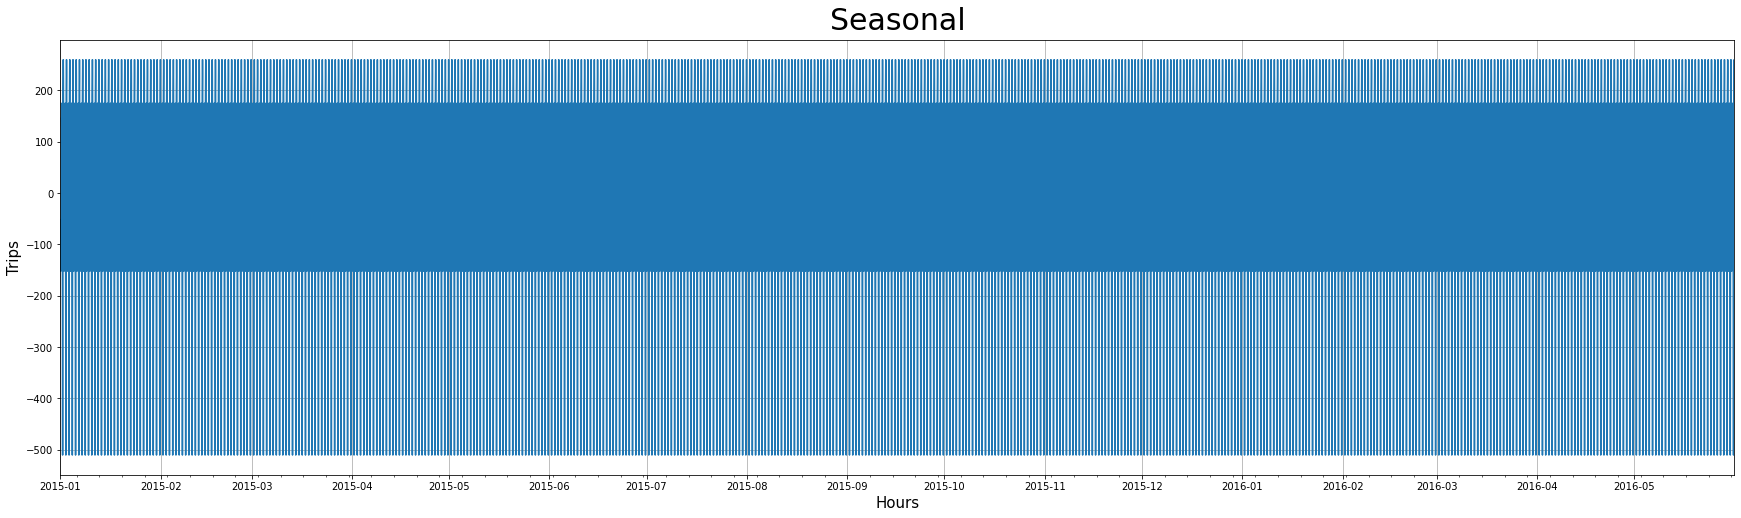

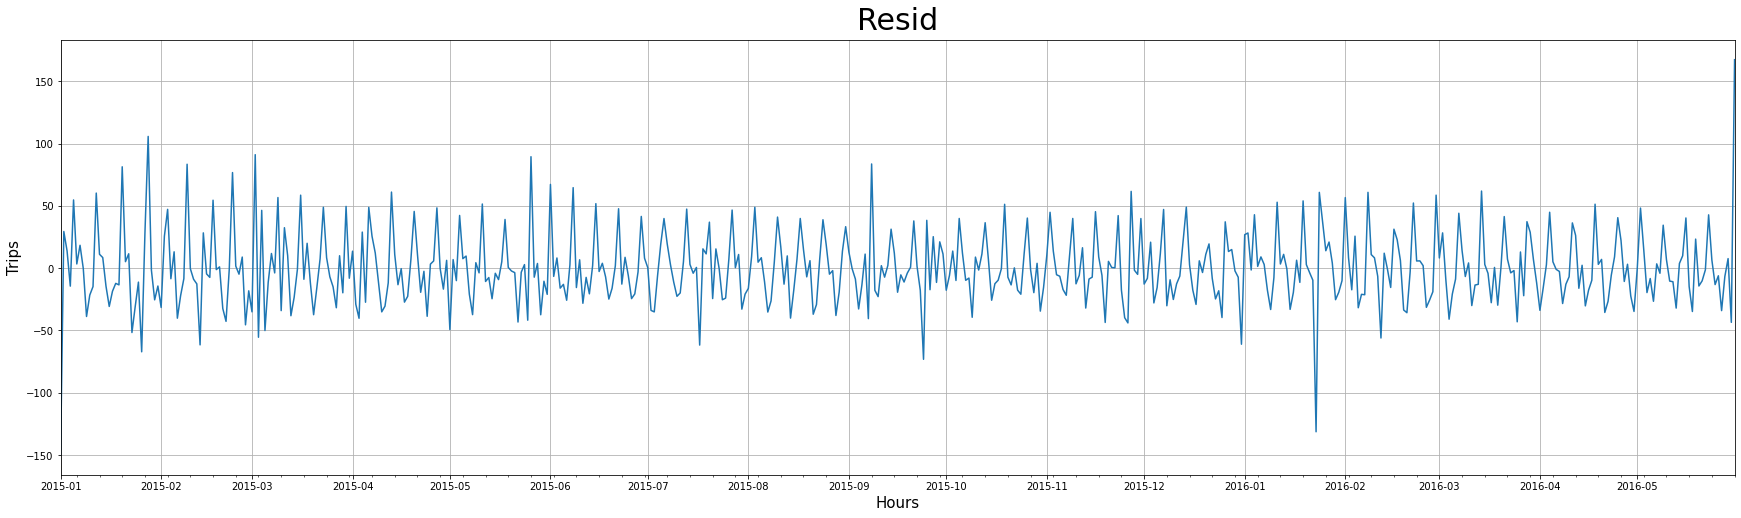

In [18]:
_ = dec_plot(cell_data['reg_resid'])

In [ ]:
# Задание 3.
# Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. 
# Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней
# (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет
# отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования
# ориентируйтесь в первую очередь на результат STL-декомпозиции.

In [19]:
# Два раза продифференцируем по cуточной сезонности. Затем применим обычное дифференцирование.

diff_period = 24
resid_col = 'reg_resid'
diff_col = 'reg_resid_diff' 
cell_data[diff_col] = cell_data[resid_col] - cell_data[resid_col].shift(diff_period)
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(diff_period)
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(1)

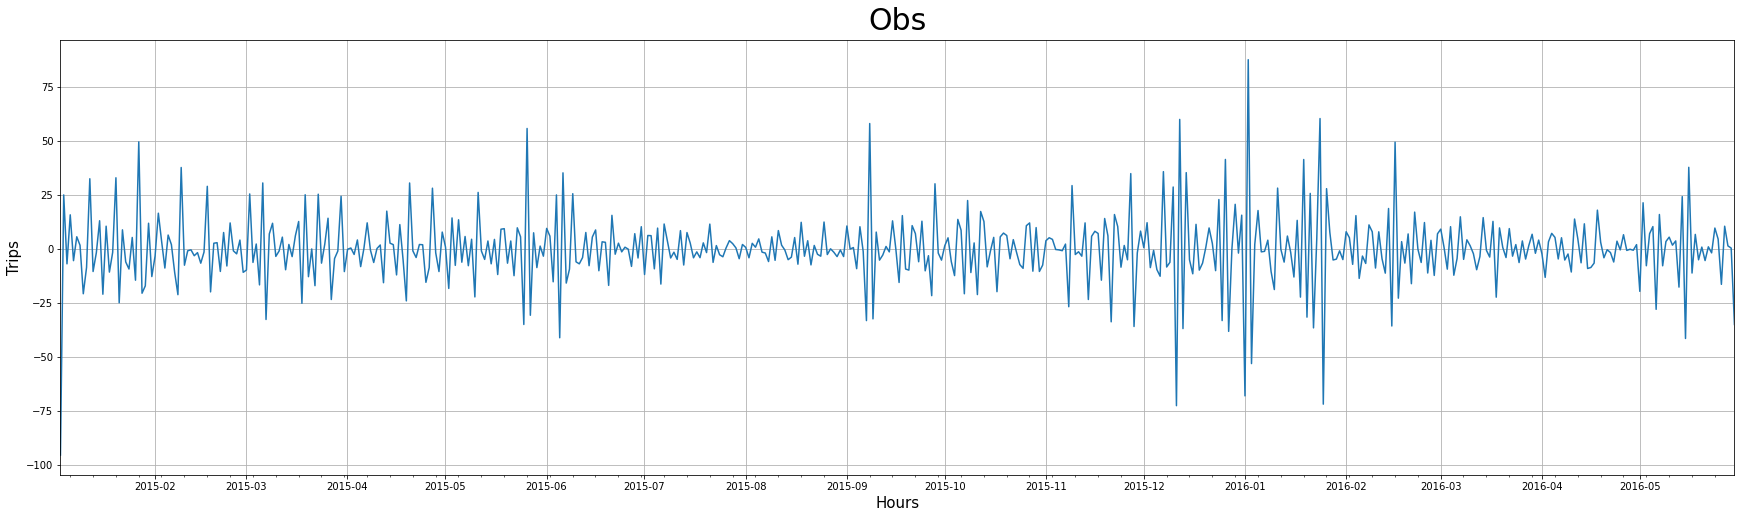

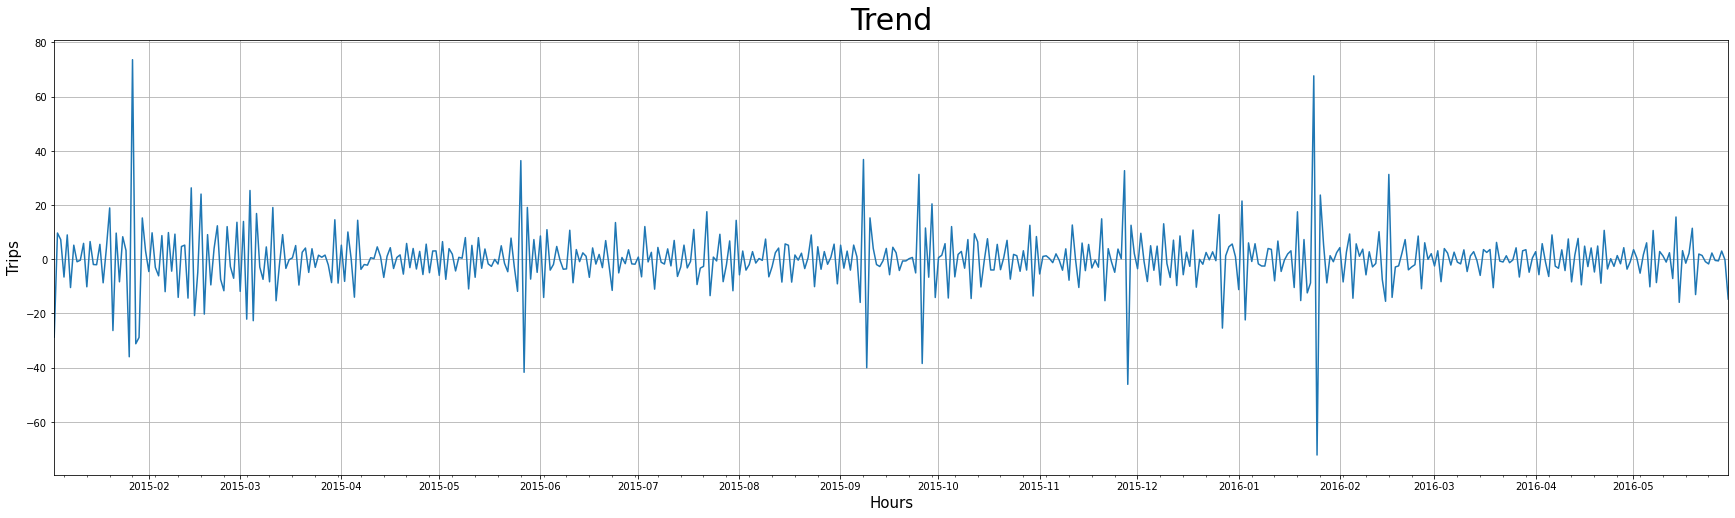

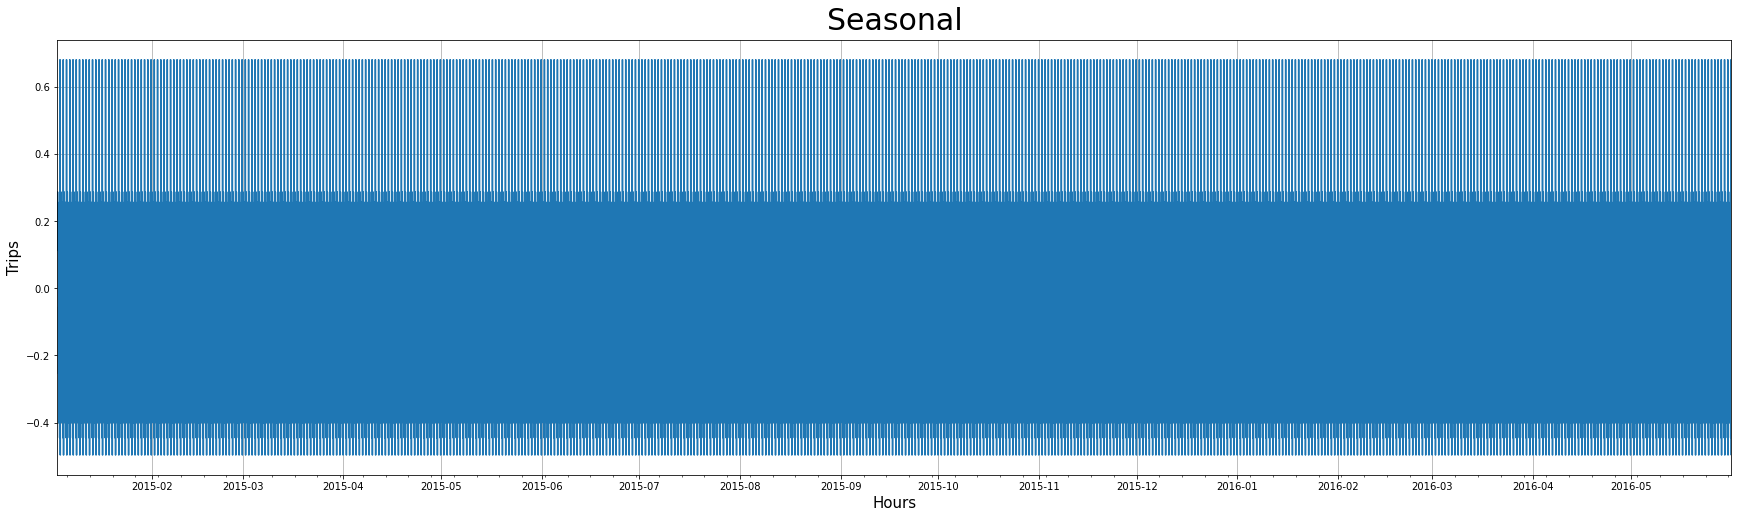

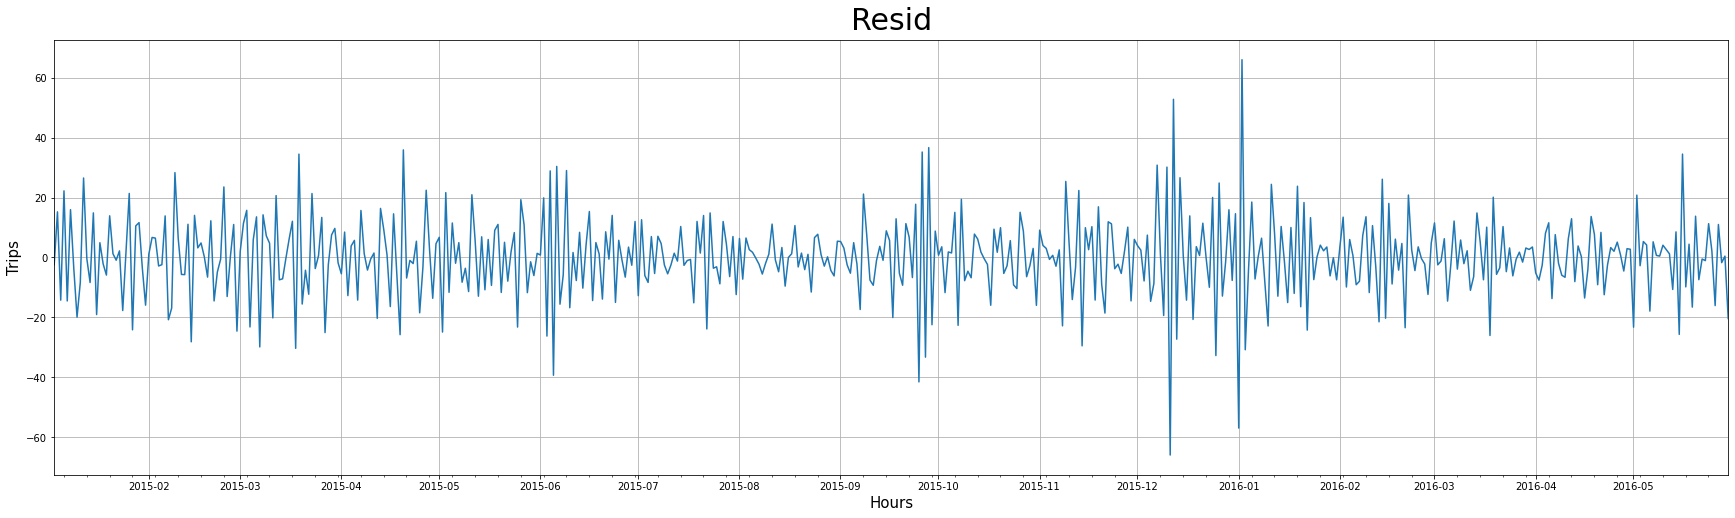

In [20]:
dec_plot(cell_data[diff_col].dropna())

In [ ]:
# Задание 4.
# Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) 
# с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год),
# подберите по ним начальные приближения для параметров p,q,P,Qp, q, P, Qp,q,P,Q. 
# Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, 
# не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

In [21]:
#### Выбор начальных приближений для p, q, P, Q

p = 23
d = 1
q = 23
P = 7
D = 2
Q = 2

In [22]:
from itertools import product

ps = [i for i in range(p+1)]
qs = [i for i in range(q+1)]
Ps = [i for i in range(P+1)]
Qs = [i for i in range(Q+1)]
parameters = product(ps, qs, Ps,Qs)
parameters = list(parameters)

In [ ]:
import warnings

results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')
print('Всего', str(len(parameters)))
i = 0
for param in parameters:
    i += 1
    print(i, '-', param, '...', datetime.now(), '...')
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit()
    
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        print('...WRONG')
        continue
    aic_res = model.aic
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

In [23]:
best_model = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], order=(0, 1, 0), 
                                        seasonal_order=(0, 2, 0, 24)).fit()
best_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          reg_resid   No. Observations:                12408
Model:             SARIMAX(0, 1, 0)x(0, 2, 0, 24)   Log Likelihood              -84335.722
Date:                            Sun, 25 Jul 2021   AIC                         168673.444
Time:                                    13:38:26   BIC                         168680.866
Sample:                                01-01-2015   HQIC                        168675.930
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       4.95e+04    425.281    116.400      0.000    4.87e+04    5.03e+04
===================================================================================
Ljung-Box (Q):                     4666.29   Jarque-Bera (JB):              2931.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
#Подобранные параметры.
p = 0
d = 1
q = 0
P = 0
D = 2
Q = 0
print('p = {}, d = {}, q = {}, P = {}, D = {}, Q = {}'.format(p, d, q, P, D, Q))

p = 0, d = 1, q = 0, P = 0, D = 2, Q = 0


In [26]:
#Получили предсказания и остатки.

cell_data['fitted_values'] = best_model.fittedvalues
cell_data['resid'] = best_model.resid
cell_data['pred'] = cell_data['reg_pred'] +  cell_data['fitted_values']

Критерий Стьюдента: p=0.99
Критерий Дики-Фуллера: p=0.0
Критерий Льюнга-Бокса: p=0.0


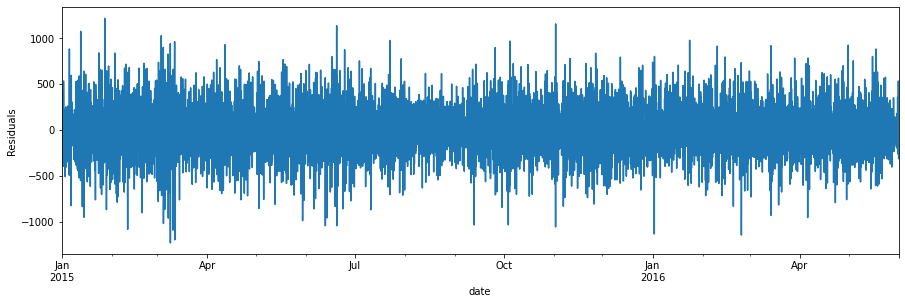

In [28]:
# Анализ остатков

plt.figure(figsize=(15,10))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel('Residuals')

print('Критерий Стьюдента: p={:.2f}'.format(stats.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print('Критерий Дики-Фуллера: p={}'.format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))
print('Критерий Льюнга-Бокса: p={}'.format(float(str(best_model.summary().tables[2]).split()[8])))

plt.show()

In [ ]:
# Задание 5.
# Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте 
# поверх предсказания выбранной модели. Если модель плохо описывает данные, 
# попробуйте увеличить количество синусов и косинусов KKK или поменять порядки дифференцирования.

In [29]:
#p = 5, d = 1, q = 15, P = 1, D = 2, Q = 0

best_model = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], order=(5, 1, 15), 
                                        seasonal_order=(1, 2, 0, 24)).fit()
best_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                           reg_resid   No. Observations:                12408
Model:             SARIMAX(5, 1, 15)x(1, 2, 0, 24)   Log Likelihood              -80933.557
Date:                             Sun, 25 Jul 2021   AIC                         161911.113
Time:                                     15:08:52   BIC                         162074.400
Sample:                                 01-01-2015   HQIC                        161965.808
                                      - 05-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7745      0.019    -95.338      0.000      -1.811      -1.738
ar.L2         -2.0162      0.033    -61.627      0.000      -2.080      -1.952
ar.L3         -1.8466      0.037    -49.882      0.000      -1.919      -1.774
ar.L4         -1.2848      0.031    -41.836      0.000      -1.345      -1.225
ar.L5         -0.5949      0.017    -35.378      0.000      -0.628      -0.562
ma.L1          1.8255      0.027     67.972      0.000       1.773       1.878
ma.L2          2.0085      0.063     32.114      0.000       1.886       2.131
ma.L3          1.6164      0.097     16.723      0.000       1.427       1.806
ma.L4          0.5297      0.119      4.466      0.000       0.297       0.762
ma.L5         -0.7548      0.124     -6.093      0.000      -0.998      -0.512
ma.L6         -1.8380      0.112    -16.362      0.000      -2.058      -1.618
ma.L7         -1.7535      0.091    -19.268      0.000      -1.932      -1.575
ma.L8         -1.4784      0.072    -20.633      0.000      -1.619      -1.338
ma.L9         -1.2705      0.054    -23.456      0.000      -1.377      -1.164
ma.L10        -0.7631      0.043    -17.953      0.000      -0.846      -0.680
ma.L11        -0.3939      0.045     -8.749      0.000      -0.482      -0.306
ma.L12        -0.0417      0.051     -0.820      0.412      -0.141       0.058
ma.L13         0.2117      0.049      4.310      0.000       0.115       0.308
ma.L14         0.5877      0.038     15.620      0.000       0.514       0.661
ma.L15         0.5144      0.017     30.227      0.000       0.481       0.548
ar.S.L24      -0.3715      0.013    -29.610      0.000      -0.396      -0.347
sigma2      4.263e+04   8.15e-05   5.23e+08      0.000    4.26e+04    4.26e+04
===================================================================================
Ljung-Box (Q):                     1914.09   Jarque-Bera (JB):               926.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+23. Standard errors may be unstable.
"""

In [30]:
cell_data['fitted_values'] = best_model.fittedvalues
cell_data['resid'] = best_model.resid
cell_data['pred'] = cell_data['reg_pred'] +  cell_data['fitted_values']

Критерий Стьюдента: p=0.95
Критерий Дики-Фуллера: p=0.0


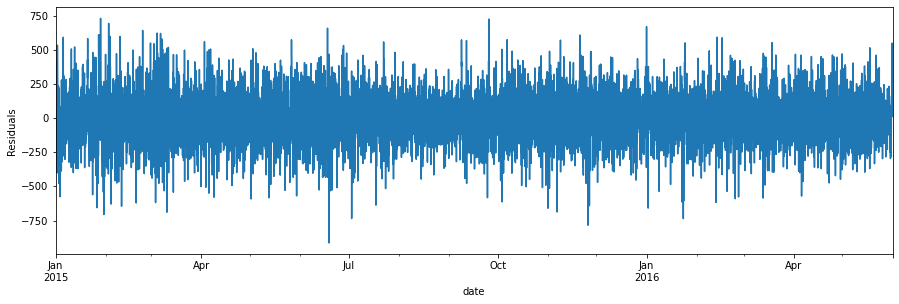

In [31]:
plt.figure(figsize=(15,10))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel('Residuals')

#ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print('Критерий Стьюдента: p={:.2f}'.format(stats.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print('Критерий Дики-Фуллера: p={}'.format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))
#print('Критерий Льюнга-Бокса: p={}'.format(float(str(best_model.summary().tables[2]).split()[8])))

plt.show()

In [ ]:
# в остатках видна структура в аномальный период

In [ ]:
# Задание 6.
# Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? 
# Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? 
# Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

In [32]:
def simple_fitted_plot(labels, trips, preds, min_lim=None, max_lim=None, title=''):
    """
    labels -список с datetime.datetime объектами
    min_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Минимальная дата отрисовки
    max_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Максимальная дата отрисовки
    title - заголовок
    """
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(labels, trips)
    ax.plot(labels, preds, color='r')
    ax.set_xlabel('Hours', fontsize=15)
    #plt.xticks(plot_hours[::label_step], plot_labels[::label_step], rotation='vertical')
    ax.set_ylabel('Trips', fontsize=15)
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    """
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('left')
    """
    ax.grid(True)
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title, fontsize=30, y=1.01)

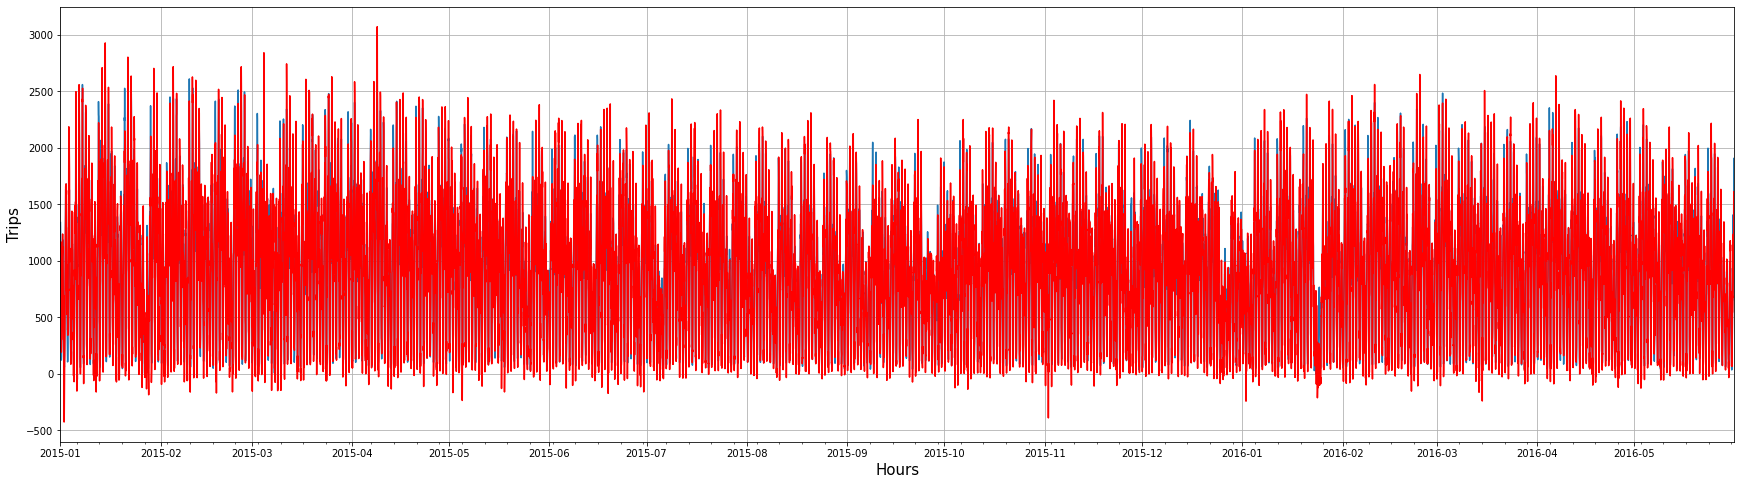

In [37]:
labels = cell_data.index
simple_fitted_plot(labels, np.array(cell_data['trips_count']), np.array(cell_data['pred']))